In [ ]:
import numpy as np
data = np.load('/disk1/yichen/temp/sam_nerf/images/0000.npz')
for k in data:
    print(k, data[k].shape)
    print(data[k])

In [1]:
from segment_anything import sam_model_registry
import torch
sam = sam_model_registry['vit_h'](checkpoint='/disk1/yichen/sam_vit_h_4b8939.pth')

device = torch.device('cuda:7')
sam = sam.to(device)

In [2]:
from segment_anything import SamPredictor
predictor = SamPredictor(sam)

In [3]:
import imageio.v3 as imageio
import cv2

image = cv2.imread('/disk1/yichen/temp/3dfront_0089_00/images/0027.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import resize

nerf_feat = np.load('/disk1/yichen/temp/sam_nerf/workspace_4/results/frames/ngp_ep0106_0027_feature.npy')
# nerf_feat = nerf_feat[0]
print(nerf_feat.shape)

nerf_feat = torch.from_numpy(nerf_feat).permute(2, 0, 1)
# nerf_feat = F.interpolate(nerf_feat.unsqueeze(0), size=(48, 64), mode='bilinear', align_corners=False).squeeze(0)
# print(nerf_feat.shape)
h, w = nerf_feat.shape[-2:]
nerf_feat = F.pad(nerf_feat, (0, 0, 0, w - h))
print(nerf_feat.shape)

# nerf_feat = data['embedding']
# nerf_feat = torch.from_numpy(nerf_feat)
# print(nerf_feat.shape)

# nerf_feat = resize(nerf_feat, (64, 64))
# print(nerf_feat.shape)

(48, 64, 256)
torch.Size([256, 64, 64])


In [5]:
predictor.features = nerf_feat.to(device).unsqueeze(0)
print(predictor.features.shape)

torch.Size([1, 256, 64, 64])


In [4]:
features = predictor.features
print(features.shape)

torch.Size([1, 256, 64, 64])


In [6]:
def forward(predictor, sam, point_coords, point_labels, features):
    if point_coords is not None:
        assert (
            point_labels is not None
        ), "point_labels must be supplied if point_coords is supplied."
        point_coords = predictor.transform.apply_coords(point_coords, predictor.original_size)
        coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=predictor.device)
        labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=predictor.device)
        coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]

    if point_coords is not None:
        points = (coords_torch, labels_torch)
    else:
        points = None

    # Embed prompts
    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
        points=points,
        boxes=None,
        masks=None,
    )

    # Predict masks
    low_res_masks, iou_predictions = sam.mask_decoder(
        image_embeddings=features,
        image_pe=sam.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=True,
    )

    # Upscale the masks to the original image resolution
    masks = sam.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)

    return masks, iou_predictions, low_res_masks

In [ ]:
feat = torch.randn(1, 256, 64, 64, device=device)
feat.requires_grad = True
optimizer = torch.optim.Adam([feat], lr=1e-3)

point_coords = np.array([[320, 220]])
point_labels = np.array([1])

for params in sam.parameters():
    params.requires_grad = False

for i in range(100):
    optimizer.zero_grad()
    predictor.features = feat
    masks, scores, low_res_masks = forward(predictor, sam, point_coords, point_labels, feat)
    print(masks.shape, scores.shape, low_res_masks.shape)
    target = torch.zeros_like(masks)
    loss = F.binary_cross_entropy_with_logits(masks, target)
    print(loss.item())

    loss.backward()
    optimizer.step()
    # print(feat.grad)

In [6]:
point_coords = np.array([[320, 220]])
point_labels = np.array([1])

masks, scores, _ = predictor.predict(point_coords=point_coords, point_labels=point_labels, multimask_output=True)
print(masks.shape, scores.shape)

(3, 480, 640) (3,)


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

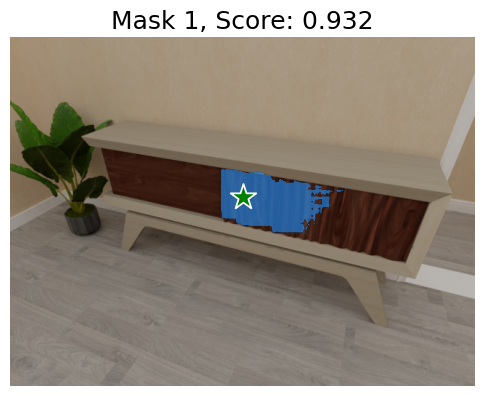

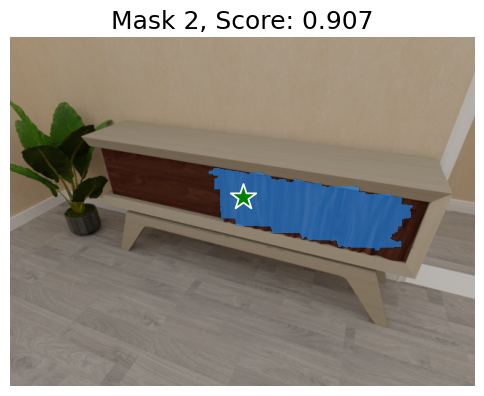

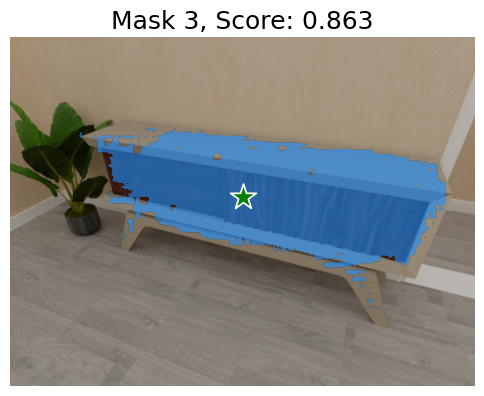

In [8]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(point_coords, point_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [ ]:
import matplotlib.pyplot as plt

print(masks.shape)
plt.imshow(masks[2])

In [14]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(img)

In [ ]:
print(masks[0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n = len(masks)
colors = np.multiply([
    plt.cm.get_cmap('gist_ncar', n)((i * 7 + 5) % n)[:3] for i in range(n)
], 255).astype(np.uint8)

mask_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
for i in range(n):
    mask_img[masks[i]['segmentation']] = colors[i]

plt.imshow(mask_img)

In [ ]:
import json
import numpy as np
import os
from tqdm import tqdm

scene_dir = '/disk1/yichen/front3d_ngp/3dfront_0089_00/train'
with open(os.path.join(scene_dir, 'transforms.json')) as f:
    scene = json.load(f)

images_dir = os.path.join(scene_dir, 'images')
frames = scene['frames']
output_dir = '/disk1/yichen/temp/sam_nerf'

os.makedirs(output_dir, exist_ok=True)
output_images_dir = os.path.join(output_dir, 'images')
os.makedirs(output_images_dir, exist_ok=True)

for frame in tqdm(frames):
    img_path = os.path.join(scene_dir, frame['file_path'])
    img = imageio.imread(img_path)

    predictor.reset_image()
    predictor.set_image(img)
    embedding = predictor.get_image_embedding()

    embedding = embedding.cpu().numpy()[0]

    print(f'original size: {img.shape[:2]}, input_size: {predictor.input_size}, encoder_img_size: {predictor.model.image_encoder.img_size}')

    np.savez_compressed(os.path.join(output_dir, frame['file_path'][:-4] + '.npz'), 
        embedding=embedding, original_size=img.shape[:2], input_size=predictor.input_size,
        encoder_img_size=predictor.model.image_encoder.img_size)

    frame['file_path'] = frame['file_path'][:-4] + '.npz'

with open(os.path.join(output_dir, 'transforms.json'), 'w') as f:
    json.dump(scene, f, indent=2)
    

In [4]:
import numpy as np

data = np.load('/disk1/yichen/nerf_rpn_dataset_release/scannet_rpn_data/scannet_split.npz')
for k in data.keys():
    print(k, data[k])

train_scenes ['scene0674_00' 'scene0394_00' 'scene0073_00' 'scene0517_00'
 'scene0646_00' 'scene0621_00' 'scene0670_00' 'scene0129_00'
 'scene0497_00' 'scene0208_00' 'scene0582_00' 'scene0390_00'
 'scene0580_00' 'scene0174_00' 'scene0505_00' 'scene0564_00'
 'scene0197_00' 'scene0550_00' 'scene0181_00' 'scene0235_00'
 'scene0026_00' 'scene0012_00' 'scene0085_00' 'scene0588_00'
 'scene0548_00' 'scene0111_00' 'scene0593_00' 'scene0046_00'
 'scene0504_00' 'scene0499_00' 'scene0576_00' 'scene0187_00'
 'scene0107_00' 'scene0250_00' 'scene0169_00' 'scene0006_00'
 'scene0412_00' 'scene0642_00' 'scene0672_00' 'scene0010_00'
 'scene0515_00' 'scene0508_00' 'scene0663_00' 'scene0247_00'
 'scene0608_00' 'scene0575_00' 'scene0249_00' 'scene0177_00'
 'scene0613_00' 'scene0644_00' 'scene0616_00' 'scene0418_00'
 'scene0678_00' 'scene0700_00' 'scene0667_00' 'scene0619_00'
 'scene0629_00' 'scene0430_00' 'scene0142_00' 'scene0286_00']
val_scenes ['scene0610_00' 'scene0246_00' 'scene0031_00' 'scene0024_00'